
# Mini Project 3 — **Asian Options**

This project focuses on an **exotic option**: the **Asian option**.

You will:
- Price **geometric-average Asian options** with **closed forms** (continuous sampling and equally spaced discrete sampling).
- Price **arithmetic-average Asian options** via **Monte Carlo**.
- Use **control variates** (geometric Asian) to reduce Monte Carlo variance.
- Visualize **convergence** with respect to the number of paths or the number of sampling steps.



## 1) Background and notation

Under the risk‑neutral measure, the underlying follows geometric Brownian motion.

$$
dS_t \;=\; S_t \,\big((r-q)\,dt + \sigma\,dW_t\big)\,.
$$

For equally spaced discrete sampling with $ N $ points at $ t_i = i\Delta t $ and $ \Delta t = T/N $, define the **geometric** and **arithmetic** averages.

$$
G_N \;=\; \exp\!\Big(\frac{1}{N}\sum_{i=1}^N \ln S_{t_i}\Big), \qquad
A_N \;=\; \frac{1}{N}\sum_{i=1}^N S_{t_i}\,.
$$

For **continuous sampling**, the geometric average is

$$
G_{\text{cont}} \;=\; \exp\!\Big(\frac{1}{T}\int_0^T \ln S_t \, dt\Big)\,.
$$

European Asian call/put payoff at maturity $ T $:

$$
\text{Call payoff} = \max(\,\text{Average} - K,\,0\,), \qquad
\text{Put payoff}  = \max(\,K - \text{Average},\,0\,)\,.
$$



## 2) Setup


In [9]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
np.random.seed(2)

# Standard normal CDF via erf
from math import erf
def Phi(x):
    return 0.5*(1.0 + erf(x / math.sqrt(2.0)))



## 3) Geometric Asian (continuous sampling)

Let

$$
Y \;=\; \frac{1}{T}\int_0^T \ln S_t \, dt\,.
$$

Under GBM, $ Y $ is normally distributed with

$$
\mathbb{E}[Y] \;=\; \ln S_0 + \big(r - q - \tfrac{1}{2}\sigma^2\big)\,\frac{T}{2}\,,
\qquad
\operatorname{Var}(Y) \;=\; \sigma^2\,\frac{T}{3}\,.
$$

Hence $ G_{\text{cont}} = e^Y $ is lognormal. The geometric‑Asian European **call** price is

$$
C_{\text{geo,cont}} \;=\; e^{-rT}\,\Big( e^{\,m + \tfrac{v}{2}}\,\Phi(d_1) \;-\; K\,\Phi(d_2) \Big)\,,
$$

with

$$
m \;=\; \mathbb{E}[Y],\quad v \;=\; \operatorname{Var}(Y),\quad
d_1 \;=\; \frac{m + v - \ln K}{\sqrt{v}},\quad d_2 \;=\; d_1 - \sqrt{v}\,.
$$

The **put** follows by symmetry or put–call parity.


In [20]:

def geometric_asian_cont_call(S0, K, r, q, sigma, T):
    # Closed-form geometric Asian call with continuous sampling
    m = math.log(S0) + (r - q - 0.5*sigma*sigma)*(T/2.0)
    v = sigma*sigma * (T/3.0)
    sqrtv = math.sqrt(v)
    d1 = (m + v - math.log(K)) / sqrtv
    d2 = d1 - sqrtv
    return math.exp(-r*T)*( math.exp(m + 0.5*v)*Phi(d1) - K*Phi(d2) )

def geometric_asian_cont_put(S0, K, r, q, sigma, T):
    # Closed-form geometric Asian put (continuous sampling)
    m = math.log(S0) + (r - q - 0.5*sigma*sigma)*(T/2.0)
    v = sigma*sigma * (T/3.0)
    sqrtv = math.sqrt(v)
    d1 = (m + v - math.log(K)) / sqrtv
    d2 = d1 - sqrtv
    return math.exp(-r*T)*( K*Phi(-d2) - math.exp(m + 0.5*v)*Phi(-d1) )

# quick check
print("Geo-Cont Call:", round(geometric_asian_cont_call(100, 100, 0.03, 0.0, float(sigma_hat), 1.0), 4))
print("Geo-Cont Put :", round(geometric_asian_cont_put(100, 100, 0.03, 0.0, float(sigma_hat), 1.0), 4))


Geo-Cont Call: 5.0865
Geo-Cont Put : 3.9477



## 4) Geometric Asian (equally spaced discrete sampling)

For $ t_i = i\Delta t $ with $ \Delta t = T/N $ and $ i=1,\dots,N $, define

$$
Y_N \;=\; \frac{1}{N}\sum_{i=1}^N \ln S_{t_i}\,.
$$

Standard results for equally spaced sampling give

$$
\mathbb{E}[Y_N] \;=\; \ln S_0 \;+\; \big(r - q - \tfrac{1}{2}\sigma^2\big)\,\frac{T(N+1)}{2N}\,,
$$

$$
\operatorname{Var}(Y_N) \;=\; \sigma^2 \, T \,\frac{(N+1)(2N+1)}{6N^2}\,.
$$

Therefore $ G_N = e^{Y_N} $ is lognormal. The geometric‑Asian **call** price is

$$
C_{\text{geo,disc}} \;=\; e^{-rT}\,\Big( e^{\,m_N + \tfrac{v_N}{2}}\,\Phi(d_1) \;-\; K\,\Phi(d_2) \Big)\,,
$$

with

$$
m_N \;=\; \mathbb{E}[Y_N],\quad v_N \;=\; \operatorname{Var}(Y_N),\quad
d_1 \;=\; \frac{m_N + v_N - \ln K}{\sqrt{v_N}},\quad d_2 \;=\; d_1 - \sqrt{v_N}\,.
$$


In [22]:

def geometric_asian_disc_call(S0, K, r, q, sigma, T, N):
    # Closed-form geometric Asian call with equally spaced discrete sampling
    mN = math.log(S0) + (r - q - 0.5*sigma*sigma) * (T*(N+1)/(2.0*N))
    vN = (sigma*sigma) * T * ((N+1)*(2*N+1)/(6.0*N*N))
    sqrtv = math.sqrt(vN)
    d1 = (mN + vN - math.log(K)) / sqrtv
    d2 = d1 - sqrtv
    return math.exp(-r*T)*( math.exp(mN + 0.5*vN)*Phi(d1) - K*Phi(d2) )

def geometric_asian_disc_put(S0, K, r, q, sigma, T, N):
    mN = math.log(S0) + (r - q - 0.5*sigma*sigma) * (T*(N+1)/(2.0*N))
    vN = (sigma*sigma) * T * ((N+1)*(2*N+1)/(6.0*N*N))
    sqrtv = math.sqrt(vN)
    d1 = (mN + vN - math.log(K)) / sqrtv
    d2 = d1 - sqrtv
    return math.exp(-r*T)*( K*Phi(-d2) - math.exp(mN + 0.5*vN)*Phi(-d1) )

# quick check
print("Geo-Disc Call (N=12):", round(geometric_asian_disc_call(100, 100, 0.03, 0.0, float(sigma_hat), 1.0, 12), 4))
print("Geo-Disc Put  (N=12):", round(geometric_asian_disc_put(100, 100, 0.03, 0.0, float(sigma_hat), 1.0, 12), 4))


Geo-Disc Call (N=12): 5.4353
Geo-Disc Put  (N=12): 4.1714



## 5) Arithmetic Asian (discrete sampling) — Monte Carlo

With $ N $ equally spaced observations, the arithmetic average is

$$
A_N \;=\; \frac{1}{N}\sum_{i=1}^N S_{t_i}\,.
$$

Under GBM, simulate paths with

$$
S_{t+\Delta t} \;=\; S_t \,\exp\!\Big((r-q - \tfrac{1}{2}\sigma^2)\,\Delta t + \sigma\sqrt{\Delta t}\,Z\Big), \quad Z\sim\mathcal{N}(0,1)\,.
$$

Monte Carlo price for a European **call**:

$$
C_{\text{arith,MC}} \;\approx\; e^{-rT}\cdot \frac{1}{M}\sum_{m=1}^M \max(A_N^{(m)} - K,\,0)\,.
$$


In [14]:

def simulate_gbm_paths(S0, r, q, sigma, T, N_steps, M_paths, seed=42):
    # Simulate M_paths GBM paths with N_steps steps
    np.random.seed(seed)
    dt = T / N_steps
    Z = np.random.normal(size=(M_paths, N_steps))
    S = np.empty((M_paths, N_steps+1))
    S[:, 0] = S0
    drift = (r - q - 0.5*sigma*sigma) * dt
    vol   = sigma * math.sqrt(dt)
    for t in range(1, N_steps+1):
        S[:, t] = S[:, t-1] * np.exp(drift + vol*Z[:, t-1])
    return S

def asian_arith_mc_call(S0, K, r, q, sigma, T, N_steps, M_paths=20000, seed=42):
    S = simulate_gbm_paths(S0, r, q, sigma, T, N_steps, M_paths, seed=seed)
    A = np.mean(S[:, 1:], axis=1)  # drop S0, average future points
    payoff = np.maximum(A - K, 0.0)
    disc = math.exp(-r*T)
    return disc * float(np.mean(payoff)), disc * float(np.std(payoff)/math.sqrt(M_paths))

# quick check
price, se = asian_arith_mc_call(100, 100, 0.03, 0.0, float(sigma_hat), 1.0, 12, 10000, seed=7)
print(f"Arithmetic Asian (MC, N=12, M=10000): {price:.4f} ± {1.96*se:.4f}")


Arithmetic Asian (MC, N=12, M=10000): 5.5276 ± 0.1608



## 6) Control variate: use geometric Asian to improve Monte Carlo

Compute, on the same paths, both arithmetic and geometric averages. Define

$$
\widehat{C}_{\text{CV}} \;=\; \widehat{C}_{\text{arith,MC}} \;-\; \beta\Big(\widehat{C}_{\text{geo,MC}} \;-\; C_{\text{geo,disc}}\Big)\,,
$$

where $ C_{\text{geo,disc}} $ is the **closed‑form** geometric‑Asian **discrete** price, and $ \beta $ is chosen approximately optimal as sample $ \mathrm{Cov}(X,Y) / \mathrm{Var}(Y) $.


In [19]:

def asian_arith_mc_call_cv(S0, K, r, q, sigma, T, N_steps, M_paths=20000, seed=42):
    S = simulate_gbm_paths(S0, r, q, sigma, T, N_steps, M_paths, seed=seed)
    A = np.mean(S[:, 1:], axis=1)
    G = np.exp(np.mean(np.log(S[:, 1:]), axis=1))

    payoff_arith = np.maximum(A - K, 0.0)
    payoff_geo   = np.maximum(G - K, 0.0)

    disc = math.exp(-r*T)
    X = payoff_arith
    Y = payoff_geo

    cov_xy = np.cov(X, Y, ddof=1)[0,1]
    var_y  = np.var(Y, ddof=1)
    beta = 0.0 if var_y == 0 else (cov_xy / var_y)

    C_geo_disc = geometric_asian_disc_call(S0, K, r, q, sigma, T, N_steps)

    est = X - beta*(Y - C_geo_disc)
    mean = float(np.mean(est))
    se   = float(np.std(est, ddof=1)/math.sqrt(M_paths))
    return disc*mean, disc*se, beta

# demo: plain MC vs control‑variate MC
S0, K, r, q, sigma, T, N, M = 100, 100, 0.03, 0.0, float(sigma_hat), 1.0, 12, 10000
plain, se_plain = asian_arith_mc_call(S0, K, r, q, sigma, T, N, M, seed=123)
cv_est, se_cv, beta = asian_arith_mc_call_cv(S0, K, r, q, sigma, T, N, M, seed=123)
print(f"Plain MC : {plain:.4f} ± {1.96*se_plain:.4f}")
print(f"CV   MC  : {cv_est:.4f} ± {1.96*se_cv:.4f} (beta≈{beta:.2f})")


Plain MC : 5.6307 ± 0.1618
CV   MC  : 5.4658 ± 0.0043 (beta≈1.03)



## 7) Convergence demos and quick summary

We examine how the arithmetic‑Asian MC estimate behaves when increasing the number of **paths $ M $** or the number of **steps $ N $**.


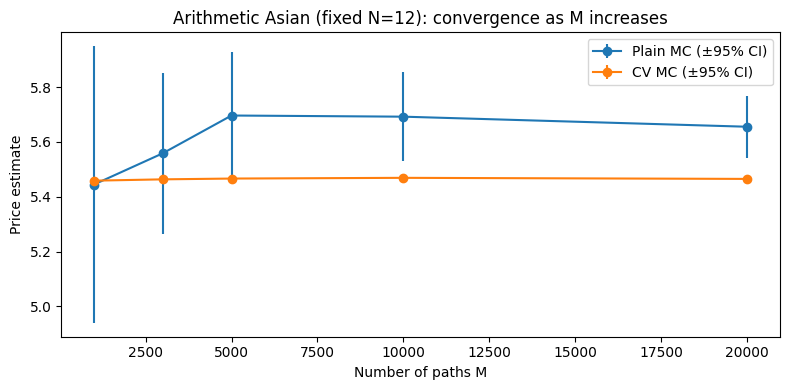

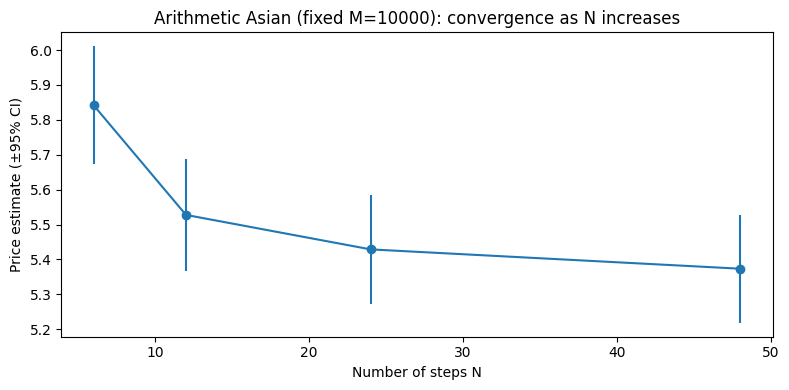

In [25]:

S0, K, r, q, sigma, T = 100, 100, 0.03, 0.0, float(sigma_hat), 1.0

# Fix N, increase M
N_fix = 12
M_list = [1000, 3000, 5000, 10000, 20000]
ests_plain, errs_plain = [], []
ests_cv, errs_cv = [], []

for M in M_list:
    est_p, se_p = asian_arith_mc_call(S0, K, r, q, sigma, T, N_fix, M, seed=42)
    est_c, se_c, _ = asian_arith_mc_call_cv(S0, K, r, q, sigma, T, N_fix, M, seed=42)
    ests_plain.append(est_p); errs_plain.append(1.96*se_p)
    ests_cv.append(est_c);   errs_cv.append(1.96*se_c)

plt.figure()
plt.errorbar(M_list, ests_plain, yerr=errs_plain, fmt='o-', label="Plain MC (±95% CI)")
plt.errorbar(M_list, ests_cv,    yerr=errs_cv,    fmt='o-', label="CV MC (±95% CI)")
plt.title("Arithmetic Asian (fixed N=12): convergence as M increases")
plt.xlabel("Number of paths M")
plt.ylabel("Price estimate")
plt.legend()
plt.tight_layout()
plt.show()

# Fix M, increase N
M_fix = 10000
N_list = [6, 12, 24, 48]
estsN, errsN = [], []
for N in N_list:
    est_p, se_p = asian_arith_mc_call(S0, K, r, q, sigma, T, N, M_fix, seed=7)
    estsN.append(est_p); errsN.append(1.96*se_p)

plt.figure()
plt.errorbar(N_list, estsN, yerr=errsN, fmt='o-')
plt.title("Arithmetic Asian (fixed M=10000): convergence as N increases")
plt.xlabel("Number of steps N")
plt.ylabel("Price estimate (±95% CI)")
plt.tight_layout()
plt.show()
